In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import datasets, linear_model, metrics, feature_extraction, model_selection, tree
from matplotlib import pyplot as plt
import seaborn as sns
import math
plt.style.use("ggplot")
%matplotlib inline
import gc
import json

In [2]:
def daysInMonth(x):
    return 28 + ((x + math.floor(x / 8)) % 2 + (2 % x) + (2 * math.floor(1/x)))


daysFromYearStart = [0]
def getDaysFromYearStart(month, day):
    while len(daysFromYearStart) <= month:
        l = len(daysFromYearStart)
        daysFromYearStart.append(daysFromYearStart[l - 1] + daysInMonth(l))
    return daysFromYearStart[month] - (daysInMonth(month) - day)


def dropRare(frame, clsName, minCount):
    counts = frame[clsName].value_counts()
    return frame.drop(df[df[clsName].isin(counts[counts < minCount].index)].index)

def logit(x):
    return math.log(np.abs(x / (1 - x)))

def logit_vec(v):
    return logit(v.mean() + 1e-5)

def reclassMeanOpt(frame, targetSrc, clsName, meanName, drop=False):
    if meanName in frame.columns:
        if drop:
            print("%s found in dataframe, drop=True, dropping" % meanName)
            frame = frame.drop(meanName, axis=1)
        else:
            print("%s found in dataframe, drop=False, skipping" % meanName)
            return frame
    mean_frame = targetSrc[[clsName, 'target']].groupby(clsName).agg(logit_vec).reset_index()
    mean_frame.rename(columns={'target':meanName}, inplace = True)
    return pd.merge(frame, mean_frame, on=clsName, how='left')
    
    
def reclassMean(frame, targetSrc, clsName, meanName, targetExtractor = lambda f, c: f[[c, 'target']].groupby(c).mean(), excluders=[]):
    def getMean(c): 
        if c not in meanInfo or c in excluders:
            meanInfo[c] = meanInfo.mean()
        return meanInfo[c]
    meanInfo = targetExtractor(targetSrc, clsName)
    frame[meanName] = frame[clsName].map(lambda c: getMean(c))
        
    
def split_time(time):
    time = str(int(time))
    time = ('0' * (4 - len(time))) + time
    hours = int(time[0:2])
    minutes = int(time[2:4])
    return {"H": hours, "M": minutes}


def reclass_time(frame, orig, hours, minutes): 
    t = frame[orig].map(split_time)
    frame[hours] = t.map(lambda t: t["H"])
    frame[minutes] = t.map(lambda t: t["M"])

In [3]:
df = pd.read_csv("train_dataset.csv")
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1


In [4]:
df = df.dropna()
df = df.drop(df[df["AirTime"] == 0].index)

In [5]:
df = dropRare(df, "FlightNum", 20)
df = dropRare(df, "Dest", 5)
df = dropRare(df, "Origin", 5)

In [6]:
df["DayOfYear"] = df.apply(lambda x: getDaysFromYearStart(x["Month"], x["DayofMonth"]), axis=1)

In [7]:
df["AirTimeFrame"] = df["AirTime"].map(lambda x: math.log((x // 30) + 1, 10))

In [8]:
reclass_time(df, "DepTime", "DepHour", "DepMinute")
df["DepTotalMinutes"] = df["DepHour"] * 60 + df["DepMinute"]
df["DepTimeFrame"] = df["DepTotalMinutes"] // 15
df["DepHourOfYear"] = df["DayOfYear"] * 24 - (24 - df["DepHour"])

In [9]:
reclass_time(df, "ArrTime", "ArrHour", "ArrMinute")
df["ArrTotalMinutes"] = df["ArrHour"] * 60 + df["ArrMinute"]
df["ArrTimeFrame"] = df["ArrTotalMinutes"] // 15
df["ArrHourOfYear"] = df["DayOfYear"] * 24 - (24 - df["ArrHour"])

In [10]:
df["DistanceFrame"] = df["Distance"].map(lambda x: math.log((x // 30) + 1, 2))

In [11]:
gc.collect()
df["DepHourOfYearFrame"] = df["DepHourOfYear"] // 8
dhoy_origin_mean = df.groupby(["DepHourOfYearFrame", "Origin"])["target"].agg(logit_vec).reset_index()
dhoy_origin_mean.rename(columns={'target': 'DHOY_OriginChance'}, inplace=True)
df = pd.merge(df, dhoy_origin_mean, on=['DepHourOfYearFrame', 'Origin'], how='left')

In [12]:
gc.collect()
df["ArrHourOfYearFrame"] = df["ArrHourOfYear"] // 8
ahoy_dest_mean = df.groupby(["ArrHourOfYearFrame", "Dest"])["target"].agg(logit_vec).reset_index()
ahoy_dest_mean.rename(columns={'target': 'AHOY_DestChance'}, inplace=True)
df = pd.merge(df, ahoy_dest_mean, on=['ArrHourOfYearFrame', 'Dest'], how='left')

In [13]:
gc.collect()

49

In [14]:
with open('../airport_info.json', 'r') as data_file:
    airport_data = json.load(fp = data_file)
    df["OTimeZone"] = df["Origin"].map(lambda x: airport_data[x]['Time Zone'])
    df["OLatitude"] = df["Origin"].map(lambda x: airport_data[x]['Latitude'])
    df["OLongitude"] = df["Origin"].map(lambda x: airport_data[x]['Longitude'])
    
    df["DTimeZone"] = df["Dest"].map(lambda x: airport_data[x]['Time Zone'])
    df["DLatitude"] = df["Dest"].map(lambda x: airport_data[x]['Latitude'])
    df["DLongitude"] = df["Dest"].map(lambda x: airport_data[x]['Longitude'])

In [15]:
df["OTimeZone"] = df["OTimeZone"].map(lambda x: int(x.split(':')[0]))
df["DTimeZone"] = df["DTimeZone"].map(lambda x: int(x.split(':')[0]))

In [76]:
df["OLtFrame"] = df["OLatitude"].astype('float').agg('floor')
df["DLtFrame"] = df["DLatitude"].astype('float').agg('floor')

df["OLgFrame"] = df["OLongitude"].astype('float').agg('floor')
df["DLgFrame"] = df["DLongitude"].astype('float').agg('floor')

In [77]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'ArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'AirTime', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'target', 'DayOfYear', 'AirTimeFrame',
       'DepHour', 'DepMinute', 'DepTotalMinutes', 'DepTimeFrame',
       'DepHourOfYear', 'ArrHour', 'ArrMinute', 'ArrTotalMinutes',
       'ArrTimeFrame', 'ArrHourOfYear', 'DistanceFrame', 'DepHourOfYearFrame',
       'DHOY_OriginChance', 'ArrHourOfYearFrame', 'AHOY_DestChance',
       'OTimeZone', 'OLatitude', 'OLongitude', 'DTimeZone', 'DLatitude',
       'DLongitude', 'DestChance', 'OTZChance', 'DLgChance', 'OLgChance',
       'AHOYChance', 'OLtChance', 'DHOYChance', 'CarrierChance', 'DLtChance',
       'DepFrameChance', 'OriginChance', 'DTZChance', 'ArrFrameChance',
       'PlaneChance', 'AirFrameChance', 'FlightChance', 'OLtFrame', 'DLtFrame',
       'OLgFrame', 'DLgFrame'],
      dtype='object')

In [78]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,OriginChance,DTZChance,ArrFrameChance,PlaneChance,AirFrameChance,FlightChance,OLtFrame,DLtFrame,OLgFrame,DLgFrame
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,...,-1.083748,-0.840467,-1.410573,-0.779533,-0.962395,-0.922062,30.0,32.0,-98.0,-98.0
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,...,-1.133766,-0.833031,-0.852247,-1.388042,-0.962395,-1.380346,44.0,42.0,-86.0,-84.0
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,...,-1.155126,-0.833031,-1.410573,-0.726567,-0.807715,-1.605656,41.0,35.0,-73.0,-79.0
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,...,-0.981517,-0.833031,-0.316832,-0.858705,-0.788335,-1.528401,36.0,40.0,-95.0,-74.0
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,...,-0.849287,-0.833031,-0.486438,-1.123099,-0.702679,-0.760838,33.0,26.0,-113.0,-81.0


In [18]:
gc.collect()

150

In [79]:
mean_names = {
    "UniqueCarrier": "CarrierChance",
    "Origin": "OriginChance",
    "Dest": "DestChance",
    "FlightNum": "FlightChance",
    "DepHourOfYear": "DHOYChance",
    "ArrHourOfYear": "AHOYChance",
    "TailNum": "PlaneChance",
    "AirTimeFrame": "AirFrameChance",
    "DepTimeFrame": "DepFrameChance",
    "ArrTimeFrame": "ArrFrameChance",
    "OTimeZone": "OTZChance",
    "DTimeZone": "DTZChance",
    "OLtFrame": "OLtChance",
    "DLtFrame": "DLtChance",
    "OLgFrame": "OLgChance",
    "DLgFrame": "DLgChance"
}

In [82]:
for orig, mean in mean_names.items():
    df = reclassMeanOpt(df, df, orig, mean)
    gc.collect()
    print("%s:%s" % (orig, mean))

DestChance found in dataframe, drop=False, skipping
Dest:DestChance
OTZChance found in dataframe, drop=False, skipping
OTimeZone:OTZChance
DLgFrame:DLgChance
DLtFrame:DLtChance
AHOYChance found in dataframe, drop=False, skipping
ArrHourOfYear:AHOYChance
OLgFrame:OLgChance
DHOYChance found in dataframe, drop=False, skipping
DepHourOfYear:DHOYChance
CarrierChance found in dataframe, drop=False, skipping
UniqueCarrier:CarrierChance
DepFrameChance found in dataframe, drop=False, skipping
DepTimeFrame:DepFrameChance
OLtFrame:OLtChance
OriginChance found in dataframe, drop=False, skipping
Origin:OriginChance
DTZChance found in dataframe, drop=False, skipping
DTimeZone:DTZChance
ArrFrameChance found in dataframe, drop=False, skipping
ArrTimeFrame:ArrFrameChance
PlaneChance found in dataframe, drop=False, skipping
TailNum:PlaneChance
AirFrameChance found in dataframe, drop=False, skipping
AirTimeFrame:AirFrameChance
FlightChance found in dataframe, drop=False, skipping
FlightNum:FlightChance


In [83]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,AirFrameChance,FlightChance,OLtFrame,DLtFrame,OLgFrame,DLgFrame,DLgChance,DLtChance,OLgChance,OLtChance
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,...,-0.962395,-0.922062,30.0,32.0,-98.0,-98.0,-0.893241,-0.908476,-0.692124,-1.108028
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,...,-0.962395,-1.380346,44.0,42.0,-86.0,-84.0,-1.151791,-0.987379,-1.108292,-1.068220
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,...,-0.807715,-1.605656,41.0,35.0,-73.0,-79.0,-0.773360,-1.026106,-1.155126,-0.643343
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,...,-0.788335,-1.528401,36.0,40.0,-95.0,-74.0,-0.686408,-0.711998,-0.946120,-0.830870
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,...,-0.702679,-0.760838,33.0,26.0,-113.0,-81.0,-0.894521,-0.765674,-0.870296,-0.799550


In [84]:
gc.collect()

66

In [77]:
df["Dest_label"] = df["Dest"].astype('category').cat.codes
df["Origin_label"] = df["Origin"].astype('category').cat.codes
df["Carrier_label"] = df["UniqueCarrier"].astype('category').cat.codes

In [126]:
used_cols = ["AirFrameChance",
             "DepFrameChance",
             "ArrFrameChance",
             "FlightChance",
             "DHOYChance",
             "AHOYChance",
             "OriginChance",
             "DestChance",
             "CarrierChance",
             "TaxiIn",
             "TaxiOut",
             "DHOY_OriginChance",
             "AHOY_DestChance",
             #"OTZChance",
             #"DTZChance",
             #"OLtChance",
             #"DLtChance",
             #"OLgChance",
             #"DLgChance"
            ]
used_cols_dec = [
    #"Month",
    #"DayofMonth",
    "DayOfWeek",
    #"Origin_label",
    #"Dest_label",
    #"Carrier_label",
    "Distance",
    "TaxiIn",
    "TaxiOut",
    #"DayOfYear",
    #"DepHourOfYear",
    #"ArrHourOfYear",
    "OLatitude",
    "OLongitude",
    "OTimeZone",
    "DLatitude",
    "DLongitude",
    "DTimeZone"
]
clf_df = df[used_cols + ["target"]]

In [127]:
clf_df.shape

(3425471, 14)

In [128]:
clf_df.head()

,AirFrameChance,DepFrameChance,ArrFrameChance,FlightChance,DHOYChance,AHOYChance,OriginChance,DestChance,CarrierChance,TaxiIn,TaxiOut,DHOY_OriginChance,AHOY_DestChance,target
0,-0.962395,-1.143192,-1.410573,-0.922062,-0.674896,-1.020730,-1.083748,-0.985542,-0.662837,15.0,13.0,-0.798461,-0.594663,1
1,-0.962395,-0.490045,-0.852247,-1.380346,0.013155,-0.180414,-1.133766,-1.211719,-1.149636,9.0,24.0,11.512935,0.044492,1
2,-0.807715,-1.547762,-1.410573,-1.605656,-1.192654,-1.020730,-1.155126,-0.791278,-0.784018,3.0,27.0,-1.203916,-0.251274,0
3,-0.788335,-0.478694,-0.316832,-1.528401,0.271974,0.537776,-0.981517,-0.626491,-0.784018,6.0,8.0,11.512935,0.200711,1
4,-0.702679,-0.827094,-0.486438,-0.760838,0.071499,0.294755,-0.849287,-0.738721,-1.182826,9.0,21.0,-0.606092,0.044492,1


In [129]:
from sklearn.utils import shuffle
shuffled_df = shuffle(clf_df)

In [130]:
labels = shuffled_df["target"]
clf_train, clf_test, label_train, label_test = model_selection.train_test_split(shuffled_df.drop("target", axis=1), labels, test_size = 0.3)

In [131]:
gc.collect()

61

In [132]:
clf = linear_model.LogisticRegression()
param_grid = {'C': [0.01, 0.1, 1, 5]}
#clf = tree.DecisionTreeClassifier()
#param_grid = {'max_depth': [3, 5, 7]}
opt = model_selection.GridSearchCV(clf, param_grid, cv=3, n_jobs=2, return_train_score=True, scoring='roc_auc')

In [133]:
opt.fit(clf_train, label_train)
#for i, c in enumerate(opt.best_estimator_.coef_[0]):
#    print("%s: %f" % (clf_df.columns[i], c))
print(opt.best_estimator_)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [93]:
for i, c in enumerate(opt.best_estimator_.coef_[0]):
    print("%s: %f" % (clf_df.columns[i], c))

AirFrameChance: 0.281628
DepFrameChance: 0.368150
ArrFrameChance: 0.035650
FlightChance: 0.411094
DHOYChance: -0.178626
AHOYChance: -0.038396
OriginChance: -0.184910
DestChance: -0.130914
CarrierChance: 0.657827
TaxiIn: -0.011807
TaxiOut: 0.002662
DHOY_OriginChance: 0.717115
AHOY_DestChance: 0.614268
OTZChance: -0.029467
DTZChance: -0.431791
OLtChance: -0.127126
DLtChance: 0.014659
OLgChance: 0.119994
DLgChance: 0.113409


In [94]:
gc.collect()

122

In [45]:
from os import system
dotfile = open('dectree.dot', 'w')
tree.export_graphviz(opt.best_estimator_, out_file=dotfile, feature_names=clf_train.columns)
dotfile.close()
system("dot -Tpng dectree.dot -o dectree.png")

0

In [95]:
predpr = opt.predict_proba(clf_test)

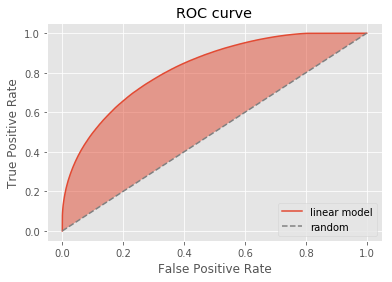

0.823269464283


In [96]:
fpr, tpr, _ = metrics.roc_curve(label_test, predpr[:,1])
plt.plot(fpr, tpr, label = 'linear model')
plt.fill(fpr, tpr, alpha=0.5)
plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = "lower right");
plt.show()
print(metrics.roc_auc_score(label_test, predpr[:,1]))

# 0.822936987323

In [97]:
test_df = pd.read_csv("test_dataset.csv")

In [98]:
test_df.shape

(3504864, 15)

In [99]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,Id
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,ORD,723,7.0,38.0,0
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,SNA,1347,7.0,24.0,1
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,PIA,130,3.0,29.0,2
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,SDF,603,6.0,14.0,3
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,BMI,533,5.0,10.0,4


In [100]:
test_df = test_df.fillna(0)

In [101]:
test_df["DayOfYear"] = test_df.apply(lambda x: getDaysFromYearStart(x["Month"], x["DayofMonth"]), axis=1)

In [102]:
test_df["AirTimeFrame"] = test_df["AirTime"].map(lambda x: math.log10(x // 30 + 1))

In [103]:
reclass_time(test_df, "DepTime", "DepHour", "DepMinute")
test_df["DepTotalMinutes"] = test_df["DepHour"] * 60 + test_df["DepMinute"]
test_df["DepTimeFrame"] = test_df["DepTotalMinutes"] // 15
test_df["DepHourOfYear"] = test_df["DayOfYear"] * 24 - (24 - test_df["DepHour"])

In [104]:
reclass_time(test_df, "ArrTime", "ArrHour", "ArrMinute")
test_df["ArrTotalMinutes"] = test_df["ArrHour"] * 60 + test_df["ArrMinute"]
test_df["ArrTimeFrame"] = test_df["ArrTotalMinutes"] // 15
test_df["ArrHourOfYear"] = test_df["DayOfYear"] * 24 - (24 - test_df["ArrHour"])

In [105]:
test_df["DepHourOfYearFrame"] = test_df["DepHourOfYear"] // 8
test_df["ArrHourOfYearFrame"] = test_df["ArrHourOfYear"] // 8

In [106]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,DepTotalMinutes,DepTimeFrame,DepHourOfYear,ArrHour,ArrMinute,ArrTotalMinutes,ArrTimeFrame,ArrHourOfYear,DepHourOfYearFrame,ArrHourOfYearFrame
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,...,1131,75,18,20,29,1229,81,20,2,2
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,...,1127,75,18,20,29,1229,81,20,2,2
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,...,922,61,15,16,22,982,65,16,1,2
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,...,1213,80,20,23,3,1383,92,23,2,2
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,...,1009,67,16,17,27,1047,69,17,2,2


In [107]:
test_df = pd.merge(test_df, dhoy_origin_mean, on=['DepHourOfYearFrame', 'Origin'], how='left')
test_df = pd.merge(test_df, ahoy_dest_mean, on=['ArrHourOfYearFrame', 'Dest'], how='left')

In [109]:
with open('../airport_info.json', 'r') as data_file:
    airport_data = json.load(fp = data_file)
    test_df["OTimeZone"] = test_df["Origin"].map(lambda x: airport_data[x]['Time Zone'])
    test_df["OLatitude"] = test_df["Origin"].map(lambda x: airport_data[x]['Latitude'])
    test_df["OLongitude"] = test_df["Origin"].map(lambda x: airport_data[x]['Longitude'])
    
    test_df["DTimeZone"] = test_df["Dest"].map(lambda x: airport_data[x]['Time Zone'])
    test_df["DLatitude"] = test_df["Dest"].map(lambda x: airport_data[x]['Latitude'])
    test_df["DLongitude"] = test_df["Dest"].map(lambda x: airport_data[x]['Longitude'])

In [110]:
test_df["OTimeZone"] = test_df["OTimeZone"].map(lambda x: int(x.split(':')[0]))
test_df["DTimeZone"] = test_df["DTimeZone"].map(lambda x: int(x.split(':')[0]))

In [111]:
test_df["OLtFrame"] = test_df["OLatitude"].astype('float').agg('floor')
test_df["DLtFrame"] = test_df["DLatitude"].astype('float').agg('floor')

test_df["OLgFrame"] = test_df["OLongitude"].astype('float').agg('floor')
test_df["DLgFrame"] = test_df["DLongitude"].astype('float').agg('floor')

In [112]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,OTimeZone,OLatitude,OLongitude,DTimeZone,DLatitude,DLongitude,OLtFrame,DLtFrame,OLgFrame,DLgFrame
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,...,-5,42.7482986,-73.8016968,-6,41.9785996,-87.9048004,42.0,41.0,-74.0,-88.0
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,...,-6,29.9843998,-95.3414001,-8,33.6757011,-117.8679962,29.0,33.0,-96.0,-118.0
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,...,-6,41.9785996,-87.9048004,-6,40.6641998,-89.6932983,41.0,40.0,-88.0,-90.0
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,...,-6,44.882,-93.2218018,-5,38.1744003,-85.7360001,44.0,38.0,-94.0,-86.0
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,...,-5,33.6366997,-84.4281006,-6,40.4771004,-88.9159012,33.0,40.0,-85.0,-89.0


In [113]:
for orig, mean in mean_names.items():
    test_df = reclassMeanOpt(test_df, df, orig, mean)
    gc.collect()
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,DHOYChance,CarrierChance,DepFrameChance,OLtChance,OriginChance,DTZChance,ArrFrameChance,PlaneChance,AirFrameChance,FlightChance
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,...,0.271974,-0.678807,-0.673394,-0.990507,-1.115451,-0.840467,-0.515531,-0.739112,NaN,-0.899933
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,...,0.271974,-0.563821,-0.673394,-0.722501,-0.676679,-0.828512,-0.515531,-0.696971,NaN,-1.078534
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,...,0.207184,-0.784018,-0.603187,-0.643343,-0.442889,-0.840467,-0.757207,-0.545388,-1.199295,-0.656061
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,...,0.750160,-1.149636,-0.108377,-1.068220,-1.026623,-0.833031,-0.022839,-1.239633,NaN,-1.201588
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,...,0.171149,-0.900070,-0.699574,-0.799550,-0.664952,-0.840467,-0.607884,-0.923573,-0.895467,-0.446774


In [114]:
gc.collect()

66

In [115]:
test_df.fillna(0, inplace=True)

In [116]:
test_clf_df = test_df[used_cols]

In [117]:
test_clf_df.shape

(3504864, 19)

In [118]:
test_clf_df.head()

,AirFrameChance,DepFrameChance,ArrFrameChance,FlightChance,DHOYChance,AHOYChance,OriginChance,DestChance,CarrierChance,TaxiIn,TaxiOut,DHOY_OriginChance,AHOY_DestChance,OTZChance,DTZChance,OLtChance,DLtChance,OLgChance,DLgChance
0,0.000000,-0.673394,-0.515531,-0.899933,0.271974,0.301462,-1.115451,-0.684491,-0.678807,7.0,38.0,11.512935,2.251408,-0.859482,-0.840467,-0.990507,-0.727910,-0.874539,-0.727904
1,0.000000,-0.673394,-0.515531,-1.078534,0.271974,0.301462,-0.676679,-0.977677,-0.563821,7.0,24.0,0.500818,0.257870,-0.767693,-0.828512,-0.722501,-0.944738,-0.706490,-0.868891
2,-1.199295,-0.603187,-0.757207,-0.656061,0.207184,-0.025278,-0.442889,-0.839503,-0.784018,3.0,29.0,1.380087,11.512935,-0.767693,-0.840467,-0.643343,-0.711998,-0.523153,-1.165108
3,0.000000,-0.108377,-0.022839,-1.201588,0.750160,1.010833,-1.026623,-0.677558,-1.149636,6.0,14.0,0.423856,0.452027,-0.767693,-0.833031,-1.068220,-0.842251,-1.050608,-0.757525
4,-0.895467,-0.699574,-0.607884,-0.446774,0.171149,0.097002,-0.664952,-0.602361,-0.900070,5.0,10.0,0.235869,0.000040,-0.859482,-0.840467,-0.799550,-0.711998,-0.741098,-0.771654


In [119]:
test_pred = opt.predict_proba(test_clf_df)

In [120]:
test_pred[:, 1]

array([ 0.99996364,  0.72746729,  0.99973738, ...,  0.54397535,
        0.22237878,  0.21948402])

In [121]:
test_pred_df = pd.DataFrame(test_pred[:, 1], columns=["Prediction1"])

In [122]:
test_pred_df.index.name = "Id"

In [123]:
test_pred_df.head()

,Prediction1
Id,
0,0.999964
1,0.727467
2,0.999737
3,0.679659
4,0.597653


In [124]:
test_pred_df.to_csv("sample_1.csv")

In [125]:
#Free ALOT of memory
test_df = test_pred_df = None
gc.collect()

48